In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geovoronoi import coords_to_points, points_to_coords, voronoi_regions_from_coords, calculate_polygon_areas,assign_points_to_voronoi_polygons
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
pd.options.mode.chained_assignment = None
import matplotlib.style
import matplotlib as mpl

from uszipcode import ZipcodeSearchEngine
search = ZipcodeSearchEngine()

# Data Import

In [3]:
data = pd.read_csv("data/15zpallagi_zipadded.csv")
hospitals = pd.read_csv("data/Hospitals.csv")
print(set([i for i in hospitals['BEDS']]))
print(hospitals[hospitals["BEDS"]==0]["BEDS"])
print(len(hospitals))
#hospitals = hospitals[hospitals['BEDS']<=0]
print(len(hospitals))


{3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223

In [4]:
points = np.column_stack((hospitals["X"],hospitals["Y"]))
points=np.unique(points,axis=0)

loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}


INFO:geovoronoi:running Voronoi tesselation for 7322 points
INFO:geovoronoi:generated 7322 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:geovoronoi:generating Voronoi polygon shapes
INFO:geovoronoi:assigning 7322 points to 7322 Voronoi polygons


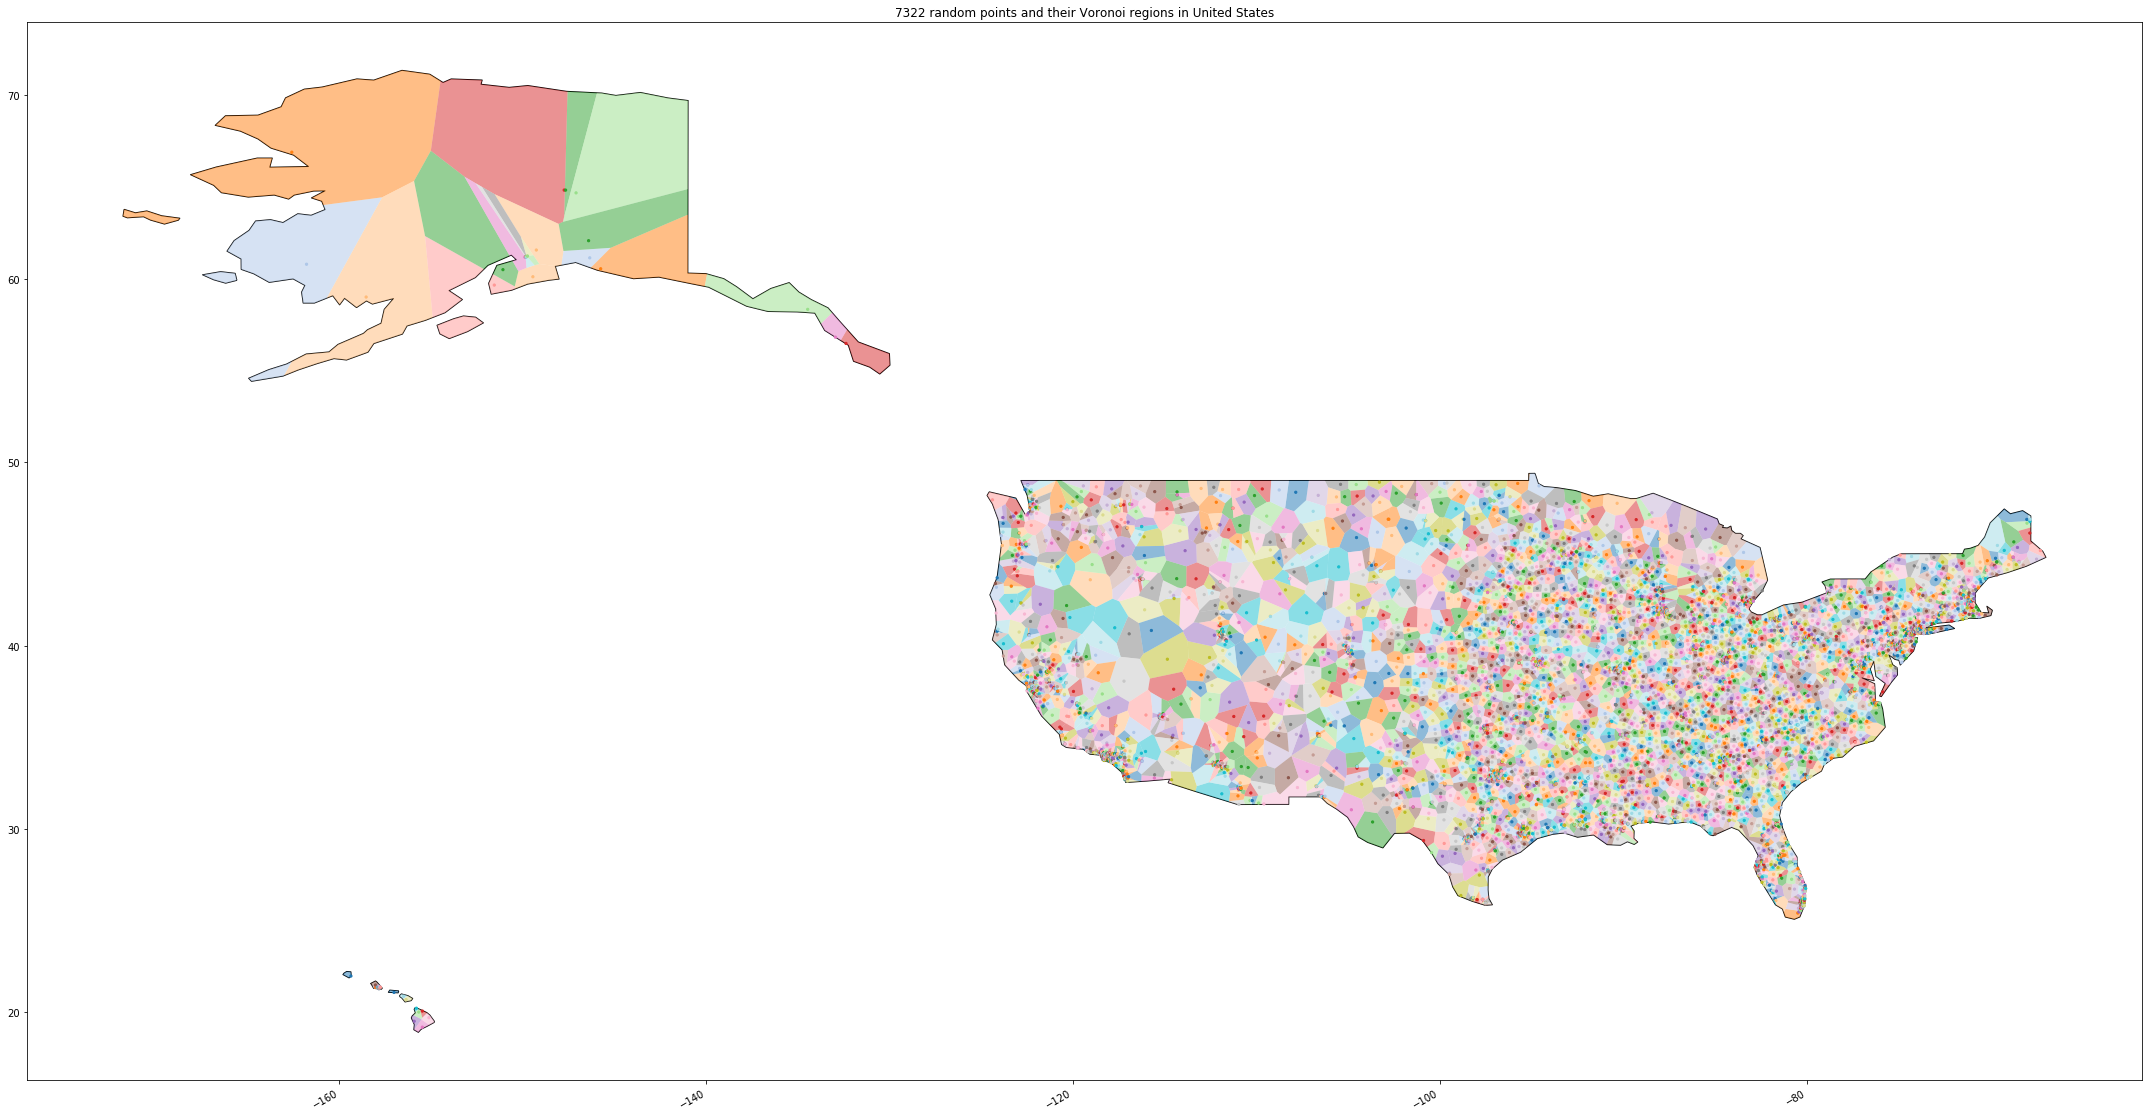

In [5]:
import logging
logging.basicConfig(level=logging.INFO)
geovoronoi_log = logging.getLogger('geovoronoi')
geovoronoi_log.setLevel(logging.INFO)
geovoronoi_log.propagate = True

COUNTRY = 'United States'

print('loading country `%s` from naturalearth_lowres' % COUNTRY)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

area = world[world.name == COUNTRY]
assert len(area) == 1

print('CRS:', area.crs)   # gives epsg:4326 -> WGS 84

coords=points

area_shape = area.iloc[0].geometry   # get the Polygon
pts = [p for p in coords_to_points(coords) if p.within(area_shape)]
coords = points_to_coords(pts)
del pts


poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(coords, area_shape,return_unassigned_points=False)
poly_areas = calculate_polygon_areas(poly_shapes, m2_to_km2=True)

fig, ax = subplot_for_map(show_x_axis=True, show_y_axis=True,figsize=(30,40))


plot_voronoi_polys_with_points_in_area(ax, area_shape, poly_shapes, coords, poly_to_pt_assignments)

ax.set_title('%d random points and their Voronoi regions in %s' % (len(pts), COUNTRY))

plt.tight_layout()
plt.savefig('random_points_and_area.png')
plt.show()


In [6]:
population = np.column_stack((data['lon'],data['lat']))

import pyproj
from shapely.geometry import shape
from shapely.ops import transform
from functools import partial

def get_area(geom):
    s = shape(geom)
    proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
                   pyproj.Proj(init='epsg:3857'))

    s_new = transform(proj, s)

    projected_area = transform(proj, s).area
    return projected_area/10000000

poly_areas = calculate_polygon_areas(poly_shapes, m2_to_km2=False)

areas= [get_area(i) for i in poly_shapes]

In [7]:
new_points = np.zeros((len(pts),2))

for i,j in enumerate(pts):
    new_points[i,0] =j.x
    new_points[i,1] = j.y

In [8]:
from scipy.spatial import cKDTree
def find_n_c2(lat_long,pop,facility):
    '''compute population in the voronoi cell of each facility and return an array'''
    
    n=0
    voronoi_kdtree = cKDTree(facility) #computes ckdtree
    
    # distance, and region
    test_point_dist, test_point_regions = voronoi_kdtree.query(lat_long, k=1) 
    
    
    # compute number of people in cell
    bin_pop = np.ones(len(facility),dtype = int)
    
    # population from each zip to each facility
    print(len(lat_long))
    print(len(pop))
    print(len(facility))

    for i in range(len(lat_long)-1):
        if test_point_regions[i]!= len(facility):
            bin_pop[test_point_regions[i]]+= pop[i]
        
    # compute distance
    bin_distance = np.zeros(len(pop))
    
    # total distance
    for i in range(len(pop)):
        bin_distance[test_point_regions[i]]+= test_point_dist[i]*pop[i]
    
    n = np.sum(bin_pop)
    c = np.sum(bin_distance)
    return bin_pop ,bin_distance, test_point_regions,n,c
bin_pop,bin_distance,test_point_regions,n,c = find_n_c2(population,data["N2"].values,new_points)


166698
166698
7322


/home/michael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


In [9]:
newbin=bin_pop[bin_pop !=1]
areas = np.array(areas)
newareas = areas[bin_pop !=1]

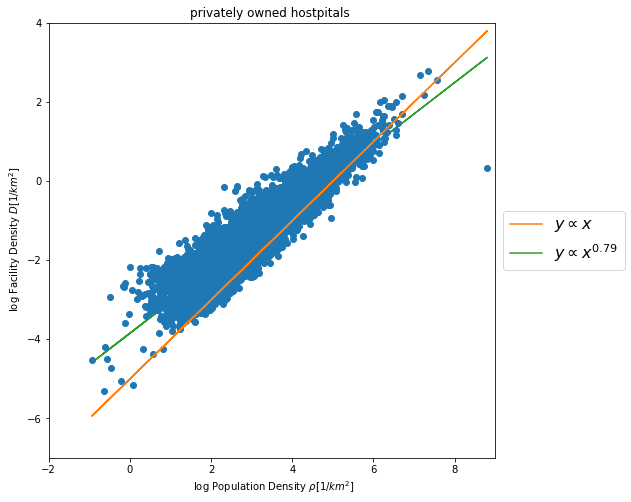

In [10]:
logx = np.log10(newbin/newareas)
logy = np.log10(1/newareas)


from scipy.optimize import curve_fit

def power_func(x,*a):
    '''power function.'''
    return a[0]+x*a[1]



a2,a2_cov = curve_fit(power_func,logx,logy,p0=(11.1,1))
#plt.style.use("danforth.mplstyle")
plt.figure(figsize=(8,8))
plt.plot( logx,logy,'o')
plt.plot(logx,logx-5,label=r"$y\propto x$")
plt.plot(logx,power_func(logx,*a2),label = r'$y \propto x^{%.2f}$'%(a2[1]),zorder=0)
plt.xlim([-2,9])
plt.ylim([-7,4])
plt.title("privately owned hostpitals ")
plt.xlabel(r' log Population Density $\rho [1/km^2]$')
plt.ylabel(r' log Facility Density $D [1/km^2]$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=16)
plt.show()




In [ ]:
print("hey")

In [ ]:
import matplotlib.style

In [ ]:
print(matplotlib.get_configdir())

In [ ]:
print(plt.style.available)

In [ ]:
plt.reload.library()

In [ ]:
plt.style.reload_library() 

In [11]:
import matplotlib
matplotlib.matplotlib_fname()

'/home/michael/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc'

In [12]:
import os
from contextlib import contextmanager

import matplotlib.pyplot as plt
from matplotlib.style.core import USER_LIBRARY_PATHS


@contextmanager
def temp_style_file(name):
    """ A context manager for creating an empty style file in the expected path.
    """
    filename = os.path.join(USER_LIBRARY_PATHS[0], name)
    with open(filename, 'w'):
        pass
    yield
    os.remove(filename)


print('# styles available:', len(plt.style.available))

with temp_style_file('danforth.mplstyle'):
    print('# before reload:', len(plt.style.available))

    plt.style.reload_library()
    print('# after reload:', len(plt.style.available))

# styles available: 25


FileNotFoundError: [Errno 2] No such file or directory: '/home/michael/.config/matplotlib/stylelib/danforth.mplstyle'